In [3]:
!python -V

Python 3.9.19


In [4]:
import pandas as pd

In [5]:
import pickle

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error, mean_squared_error

In [8]:
import mlflow

In [9]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-eperiment")

<Experiment: artifact_location='/home/penscola/Project/MLflow-Experiment-Tracking/mlruns/2', creation_time=1722685589483, experiment_id='2', last_update_time=1722685589483, lifecycle_stage='active', name='nyc-taxi-eperiment', tags={}>

In [10]:
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [11]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

9.838799799829628

/tmp/ipykernel_5269/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_5269/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


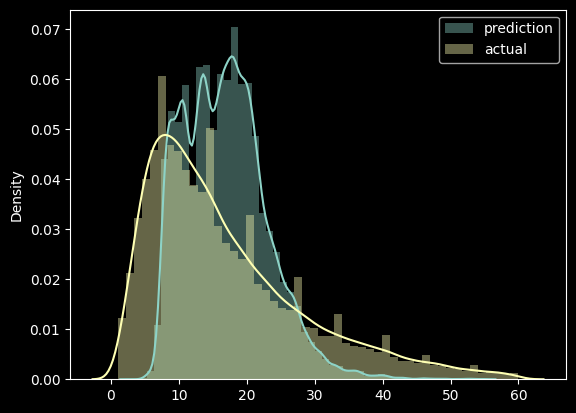

In [12]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [13]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [14]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [15]:
len(df_train), len(df_val)

(73908, 61921)

In [16]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [17]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [18]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [19]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

7.758715200888857

In [20]:
with open('./models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [21]:
with mlflow.start_run():

    mlflow.set_tag('dev', 'Felix')
    mlflow.log_param('train-data-path', './data/green_tripdata_2021-01.parquet')
    mlflow.log_param('valid-data-path', './data/green_tripdata_2021-02.parquet')

    alpha = 0.1
    mlflow.log_param('alpha', alpha)

    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric('rmse', rmse)

    mlflow.log_artifact(local_path='./models/lin_reg.bin', artifact_path='models_pickel')

In [22]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [23]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [24]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=10,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [25]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=5,
    trials=Trials()
)

  0%|          | 0/5 [00:00<?, ?trial/s, best loss=?]

/home/penscola/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:26:13] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.20704                          
[1]	validation-rmse:6.99781                          
[2]	validation-rmse:6.64826                          
[3]	validation-rmse:6.52913                          
[4]	validation-rmse:6.48426                          
[5]	validation-rmse:6.46200                          
[6]	validation-rmse:6.44669                          
[7]	validation-rmse:6.43588                          
[8]	validation-rmse:6.42882                          
[9]	validation-rmse:6.42490                          
 20%|██        | 1/5 [00:18<01:12, 18.18s/trial, best loss: 6.424899838447506]

/home/penscola/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/penscola/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:26:31] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.20216                                                   
[1]	validation-rmse:7.07044                                                   
[2]	validation-rmse:6.76990                                                   
[3]	validation-rmse:6.65943                                                   
[4]	validation-rmse:6.61417                                                   
[5]	validation-rmse:6.59327                                                   
[6]	validation-rmse:6.58149                                                   
[7]	validation-rmse:6.56732                                                   
[8]	validation-rmse:6.56289                                                   
[9]	validation-rmse:6.55878                                                   
 40%|████      | 2/5 [00:25<00:35, 11.81s/trial, best loss: 6.424899838447506]

/home/penscola/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/penscola/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:26:38] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.76935                                                  
[1]	validation-rmse:11.35631                                                  
[2]	validation-rmse:10.97263                                                  
[3]	validation-rmse:10.61616                                                  
[4]	validation-rmse:10.28528                                                  
[5]	validation-rmse:9.97855                                                   
[6]	validation-rmse:9.69479                                                   
[7]	validation-rmse:9.43261                                                   
[8]	validation-rmse:9.19050                                                   
[9]	validation-rmse:8.96684                                                   
 60%|██████    | 3/5 [01:07<00:51, 25.74s/trial, best loss: 6.424899838447506]

/home/penscola/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/penscola/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:27:21] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.79617                                                  
[1]	validation-rmse:11.40701                                                  
[2]	validation-rmse:11.04414                                                  
[3]	validation-rmse:10.70606                                                  
[4]	validation-rmse:10.39141                                                  
[5]	validation-rmse:10.09896                                                  
[6]	validation-rmse:9.82716                                                   
[7]	validation-rmse:9.57529                                                   
[8]	validation-rmse:9.34138                                                   
[9]	validation-rmse:9.12474                                                   
 80%|████████  | 4/5 [01:24<00:22, 22.05s/trial, best loss: 6.424899838447506]

/home/penscola/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/penscola/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:27:37] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.20478                                                  
[1]	validation-rmse:10.36477                                                  
[2]	validation-rmse:9.66975                                                   
[3]	validation-rmse:9.09814                                                   
[4]	validation-rmse:8.63176                                                   
[5]	validation-rmse:8.25262                                                   
[6]	validation-rmse:7.94650                                                   
[7]	validation-rmse:7.70041                                                   
[8]	validation-rmse:7.50265                                                   
[9]	validation-rmse:7.34406                                                   
100%|██████████| 5/5 [01:32<00:00, 18.46s/trial, best loss: 6.424899838447506]


/home/penscola/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



In [26]:
params = {
    'learning_rate': 0.3105810690340803,
    'max_depth': 26,
    'min_child_weight': 2.8382734337613917,
    'objective': 'reg:linear',
    'reg_alpha': 0.15662394644518382,
    'reg_lambda': 0.030948550204662174,
    'seed': 42
}

mlflow.xgboost.autolog()

booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=50,
            evals=[(valid, 'validation')],
            early_stopping_rounds=10
        )

2024/08/08 14:27:45 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.


2024/08/08 14:27:45 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '48ce990413f149a48eb747750632bd63', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow
/home/penscola/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:27:58] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:9.82107
[1]	validation-rmse:8.40838
[2]	validation-rmse:7.60105
[3]	validation-rmse:7.15449
[4]	validation-rmse:6.90881
[5]	validation-rmse:6.77077
[6]	validation-rmse:6.68541
[7]	validation-rmse:6.63248
[8]	validation-rmse:6.59847
[9]	validation-rmse:6.57522
[10]	validation-rmse:6.56086
[11]	validation-rmse:6.54798
[12]	validation-rmse:6.53850
[13]	validation-rmse:6.53306
[14]	validation-rmse:6.53037
[15]	validation-rmse:6.52807
[16]	validation-rmse:6.52524
[17]	validation-rmse:6.52184
[18]	validation-rmse:6.51808
[19]	validation-rmse:6.51418
[20]	validation-rmse:6.51078
[21]	validation-rmse:6.50904
[22]	validation-rmse:6.50761
[23]	validation-rmse:6.50557
[24]	validation-rmse:6.49982
[25]	validation-rmse:6.49779
[26]	validation-rmse:6.49465
[27]	validation-rmse:6.49246
[28]	validation-rmse:6.49004
[29]	validation-rmse:6.48861
[30]	validation-rmse:6.48681
[31]	validation-rmse:6.48359
[32]	validation-rmse:6.48137
[33]	validation-rmse:6.47922
[34]	validation-rmse:6.4

2024/08/08 14:28:29 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2024/08/08 14:28:29 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/penscola/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:28:29] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2024/08/08 14:28:34 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


In [28]:
mlflow.xgboost.autolog(disable=True)

In [29]:
with mlflow.start_run():
    params = {
        'learning_rate': 0.3105810690340803,
        'max_depth': 26,
        'min_child_weight': 2.8382734337613917,
        'objective': 'reg:linear',
        'reg_alpha': 0.15662394644518382,
        'reg_lambda': 0.030948550204662174,
        'seed': 42
    }

    mlflow.log_params(params)

    booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=50,
            evals=[(valid, 'validation')],
            early_stopping_rounds=10
        )
    
    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

    with open('models/preprocessor.b', 'wb') as f_out:
        pickle.dump(dv, f_out)

    mlflow.log_artifact('models/preprocessor.b', artifact_path='preprocessor')

    mlflow.xgboost.log_model(booster, 'xgboost-model')

/home/penscola/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:30:28] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:9.82107
[1]	validation-rmse:8.40838
[2]	validation-rmse:7.60105
[3]	validation-rmse:7.15449
[4]	validation-rmse:6.90881
[5]	validation-rmse:6.77077
[6]	validation-rmse:6.68541
[7]	validation-rmse:6.63248
[8]	validation-rmse:6.59847
[9]	validation-rmse:6.57522
[10]	validation-rmse:6.56086
[11]	validation-rmse:6.54798
[12]	validation-rmse:6.53850
[13]	validation-rmse:6.53306
[14]	validation-rmse:6.53037
[15]	validation-rmse:6.52807
[16]	validation-rmse:6.52524
[17]	validation-rmse:6.52184
[18]	validation-rmse:6.51808
[19]	validation-rmse:6.51418
[20]	validation-rmse:6.51078
[21]	validation-rmse:6.50904
[22]	validation-rmse:6.50761
[23]	validation-rmse:6.50557
[24]	validation-rmse:6.49982
[25]	validation-rmse:6.49779
[26]	validation-rmse:6.49465
[27]	validation-rmse:6.49246
[28]	validation-rmse:6.49004
[29]	validation-rmse:6.48861
[30]	validation-rmse:6.48681
[31]	validation-rmse:6.48359
[32]	validation-rmse:6.48137
[33]	validation-rmse:6.47922
[34]	validation-rmse:6.4

/home/penscola/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/penscola/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:30:50] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
/home/penscola/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is 

In [30]:
logged_model = 'runs:/853e49ef71004c159997bfea58e99af4/xgboost-model'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

In [31]:
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: xgboost-model
  flavor: mlflow.xgboost
  run_id: 853e49ef71004c159997bfea58e99af4

In [32]:
xgboost_model = mlflow.xgboost.load_model(logged_model)

In [33]:
xgboost_model

In [34]:
y_pred = xgboost_model.predict(valid)

In [35]:
y_pred[:10]

array([15.197158,  7.141074, 18.203512, 24.409086,  9.720639, 17.04918 ,
       13.990421,  8.615835,  8.973498, 19.213602], dtype=float32)